In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from math import sqrt
import plotly.graph_objects as go
import statsmodels.api as sm
import math
import plotly.express as px
import random
import re
import os

In [ ]:
import os

os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/interim', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_netflix= pd.read_csv('/content/drive/MyDrive/netflix_titles.csv', usecols=['show_id','title','director','cast','listed_in','description'])
df_titles= pd.read_csv('/content/drive/MyDrive/titles.csv', usecols=['id','title','type','genres','imdb_votes','imdb_score','tmdb_popularity','tmdb_score'])
df_credits= pd.read_csv('/content/drive/MyDrive/credits.csv')
df_imdb= pd.read_csv('/content/drive/MyDrive/imdb_top_1000.csv', usecols=['Series_Title', 'Gross'])

In [ ]:
df_netflix['title'] = df_netflix['title'].str.lower().str.strip()
df_titles['title'] = df_titles['title'].str.lower().str.strip()
df_imdb['Series_Title']= df_imdb['Series_Title'].str.lower().str.strip()
df_imdb['Gross']= df_imdb['Gross'].str.lower().str.strip()

In [ ]:
def clean_title(text):
    if isinstance(text, str):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)
    else:
        return text

df_netflix['title'] = df_netflix['title'].apply(clean_title)
df_titles['title'] = df_titles['title'].apply(clean_title)
df_imdb['Series_Title'] = df_imdb['Series_Title'].apply(clean_title)


In [ ]:
def remove_suffix(title):
    if isinstance(title, str):  # Checking if the input is a string
        if title.endswith('the movie'):
            return title[:-9].strip()
    return title

# Applying the remove_suffix function to the 'title' column of each DataFrame
df_netflix['title'] = df_netflix['title'].apply(remove_suffix)
df_titles['title'] = df_titles['title'].apply(remove_suffix)
df_imdb['Series_Title'] = df_imdb['Series_Title'].apply(remove_suffix)


In [ ]:
merged_df = pd.merge(df_titles, df_credits, on='id', how='inner')
remerged_df = pd.merge(merged_df, df_netflix, on='title', how='inner')
reremerged_df = pd.merge(remerged_df, df_imdb[['Series_Title', 'Gross']], left_on='title', right_on='Series_Title', how='inner')

In [ ]:
remerged_df

In [ ]:

reremerged_df

In [ ]:
print(reremerged_df[['title', 'Series_Title']].sample(5))

In [ ]:
mismatches = reremerged_df[reremerged_df['title'] != reremerged_df['Series_Title']]
print(f"Number of mismatches: {len(mismatches)}")

if len(mismatches) > 0:
    print("Here are some mismatches:")
    print(mismatches[['title', 'Series_Title']].head())

In [ ]:
reremerged_df.drop('Series_Title', axis=1, inplace=True)

In [ ]:
reremerged_df.info()

In [ ]:
reremerged_df.describe()

In [ ]:
print(reremerged_df.isnull().sum())

In [ ]:
reremerged_df.columns = reremerged_df.columns.str.title()

In [ ]:
reremerged_df['Imdb_Score'].fillna(reremerged_df['Imdb_Score'].mean(), inplace=True)

reremerged_df['Imdb_Votes'].fillna(reremerged_df['Imdb_Votes'].median(), inplace=True)

reremerged_df['Tmdb_Score'].fillna(reremerged_df['Tmdb_Score'].mean(), inplace=True)

reremerged_df['Director'].fillna('Unknown', inplace=True)

reremerged_df['Character'].fillna('Unknown', inplace=True)

most_common_cast = reremerged_df['Cast'].mode()[0]
reremerged_df['Cast'].fillna(most_common_cast, inplace=True)

# Removing commas
reremerged_df['Gross'] = reremerged_df['Gross'].replace(',', '', regex=True)

# Conversion process
reremerged_df['Gross'] = reremerged_df['Gross'].astype(float)

# Comma separated values can now be treated as decimals when calculating median
gross_median = reremerged_df['Gross'].median()
reremerged_df['Gross'].fillna(gross_median, inplace=True)

In [ ]:
print(reremerged_df.isnull().sum())

In [ ]:
duplicate_rows = reremerged_df.duplicated().sum()

print("Number of duplicate rows:", duplicate_rows)

In [ ]:
reremerged_df

In [ ]:

from scipy import stats
z_scores = stats.zscore(reremerged_df['Imdb_Score'])

threshold = 3
outliers = np.where(np.abs(z_scores) > threshold)

print("location of all outliers:", outliers)

In [ ]:
#replace outliers with average
reremerged_df['Imdb_Score'].loc[outliers[0]] = reremerged_df['Imdb_Score'].mean()

In [ ]:
#outliers for gross
z_scores_gross = stats.zscore(reremerged_df['Gross'])
outliers_gross = np.where(np.abs(z_scores_gross) > threshold)
print("gross outliers location:", outliers_gross)

In [ ]:
#filling outliers with median
median_value = reremerged_df['Gross'].median()
reremerged_df.loc[outliers_gross[0], 'Gross'] = median_value

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(reremerged_df['Imdb_Score'], reremerged_df['Tmdb_Score'], alpha=0.5)
plt.title('Correlation btw IMDb Score and TMDB Score')
plt.xlabel('IMDb Score')
plt.ylabel('TMDB Score')
plt.grid(True)
plt.show()

In [ ]:
top_genres = reremerged_df['Genres'].value_counts().head(10).index

filtered_df = reremerged_df[reremerged_df['Genres'].isin(top_genres)]

plt.figure(figsize=(12, 8))
sns.boxplot(x='Genres', y='Imdb_Score', data=filtered_df)
plt.title('Audience Scores by Genre')
plt.xlabel('Genres')
plt.ylabel('IMDb Score')
plt.xticks(rotation=45)
plt.show()

In [ ]:
director_avg_imdb_scores = reremerged_df.groupby('Name')['Imdb_Score'].mean().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='Name', y='Imdb_Score', data=director_avg_imdb_scores.head(10))
plt.title('Top 10 Directors by Average IMDb Score')
plt.xlabel('Director')
plt.ylabel('Average IMDb Score')
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(reremerged_df['Gross'], reremerged_df['Imdb_Score'], alpha=0.5)
plt.title('IMDb Scores vs. Gross Income')
plt.xlabel('Gross Income')
plt.ylabel('IMDb Score')
plt.show()

In [ ]:
import pandas as pd

# Veri setlerini yükleme
df_credits = pd.read_csv('/content/data/raw/credits.csv')
df_titles = pd.read_csv('/content/data/raw/titles.csv')

# Credits ve titles veri setlerini birleştirme
df_merged = pd.merge(df_credits, df_titles, on='id', how='inner')

# Aktörler için popülerlik indeksi hesaplama
actor_popularity = df_merged[df_merged['role'] == 'ACTOR'].groupby('name')['imdb_score'].mean().reset_index()
actor_popularity.columns = ['Name', 'Actor_Popularity_Index']

# Yönetmenler için popülerlik indeksi hesaplama
director_popularity = df_merged[df_merged['role'] == 'DIRECTOR'].groupby('name')['imdb_score'].mean().reset_index()
director_popularity.columns = ['Name', 'Director_Popularity_Index']

# Popülerlik indekslerini birleştirme
popularity_df = pd.concat([actor_popularity, director_popularity], ignore_index=True)

# Popülerlik indeksini orijinal veri çerçevesine ekleme fonksiyonu
def get_popularity_index(row, popularity_df):
    if row['Role'] == 'ACTOR':
        popularity_score = popularity_df[popularity_df['Name'] == row['Name']]['Actor_Popularity_Index'].values
    elif row['Role'] == 'DIRECTOR':
        popularity_score = popularity_df[popularity_df['Name'] == row['Name']]['Director_Popularity_Index'].values
    else:
        popularity_score = [0]

    return popularity_score[0] if len(popularity_score) > 0 else 0

# Orijinal veri çerçevesine popülerlik indeksini ekleme
reremerged_df['Popularity_Index'] = reremerged_df.apply(lambda row: get_popularity_index(row, popularity_df), axis=1)

# Sonuçları kontrol etme
print(reremerged_df.head())


In [ ]:
# Popülerlik indekslerinin istatistiklerini gözden geçirme
print(reremerged_df['Popularity_Index'].describe())

In [ ]:
reremerged_df

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Gereksiz sütunları çıkarma
X = reremerged_df.drop(columns=['Imdb_Score', 'Id', 'Title', 'Type', 'Description', 'Show_Id', 'Listed_In', 'Cast', 'Character'])
y = reremerged_df['Imdb_Score']

# Kategorik ve sayısal sütunları belirleme
categorical_features = ['Genres', 'Role', 'Director', 'Name']
numeric_features = X.columns.difference(categorical_features)

# Kategorik ve sayısal sütunları dönüştürmek için ön işleme adımları
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])

# Ön işleme adımları birleştirme
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline oluşturma
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Eğitim ve test veri setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli eğitme
model.fit(X_train, y_train)

# Test veri seti ile tahminler yapma
y_pred = model.predict(X_test)

# Performans metrikleri
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Gerçek ve tahmin edilen değerlerin karşılaştırması
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Gerçek IMDb Puanı")
plt.ylabel("Tahmin Edilen IMDb Puanı")
plt.title("Gerçek ve Tahmin Edilen IMDb Puanlarının Karşılaştırması")
plt.show()


Index(['Id', 'Title', 'Type', 'Genres', 'Imdb_Score', 'Imdb_Votes',
       'Tmdb_Popularity', 'Tmdb_Score', 'Person_Id', 'Name', 'Character',
       'Role', 'Show_Id', 'Director', 'Cast', 'Listed_In', 'Description',
       'Gross', 'Popularity_Index'],
      dtype='object')
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Random Forest Mean Squared Error: 1.7323496981696862
Random Forest R^2 Score: 0.7529654672194624


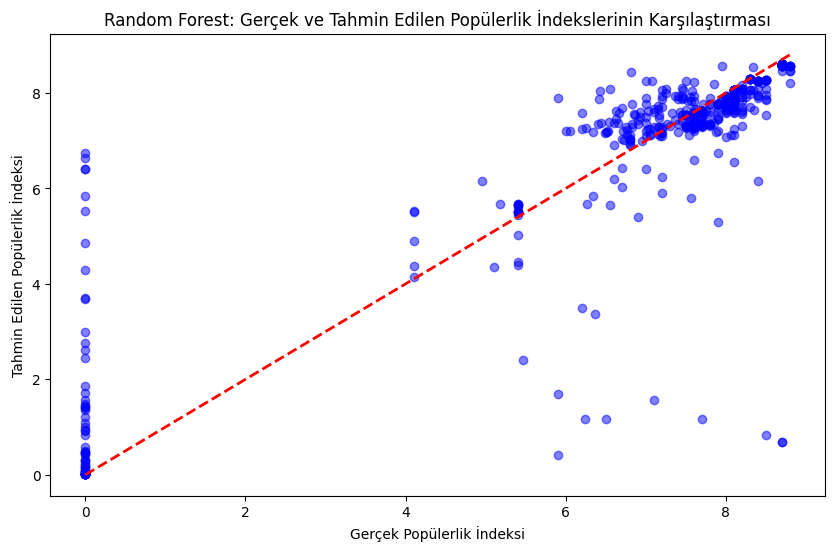

   Gerçek Değer  Tahmin Edilen Değer
0      6.766667             7.126585
1      8.300000             8.052610
2      6.700000             6.424891
3      7.800000             7.318151
4      8.200000             8.083725
5      4.950000             6.145672
6      0.000000             0.023823
7      6.511111             7.179416
8      7.600000             7.415069
9      0.000000             0.450642


In [192]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Sütun adını kontrol etme
print(reremerged_df.columns)

# Türleri patlatma (explode) işlemi
exploded_df = reremerged_df.explode('Genres')

# Gereksiz sütunları çıkarma
X = exploded_df.drop(columns=['Popularity_Index', 'Id', 'Title', 'Type', 'Description', 'Show_Id', 'Listed_In', 'Cast', 'Character'])
y = exploded_df['Popularity_Index']

# Eksik değerleri kontrol etme ve doldurma
imputer = SimpleImputer(strategy='median')
y = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Kategorik ve sayısal sütunları belirleme
categorical_features = ['Genres', 'Role', 'Director', 'Name']
numeric_features = X.columns.difference(categorical_features)

# Kategorik ve sayısal sütunları dönüştürmek için ön işleme adımları
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])

# Ön işleme adımları birleştirme
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline oluşturma
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hiperparametre grid'i
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

# Grid Search CV ile hiperparametre optimizasyonu
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Eğitim ve test veri setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli eğitme
grid_search.fit(X_train, y_train)

# En iyi modeli seçme
best_rf_model = grid_search.best_estimator_

# Test veri seti ile tahminler yapma
y_pred_rf = best_rf_model.predict(X_test)

# Performans metrikleri
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

# Gerçek ve tahmin edilen değerlerin karşılaştırması
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Gerçek Popülerlik İndeksi")
plt.ylabel("Tahmin Edilen Popülerlik İndeksi")
plt.title("Random Forest: Gerçek ve Tahmin Edilen Popülerlik İndekslerinin Karşılaştırması")
plt.show()

# İlk birkaç tahmin ve gerçek değeri karşılaştırma
comparison_df_rf = pd.DataFrame({'Gerçek Değer': y_test, 'Tahmin Edilen Değer': y_pred_rf})
print(comparison_df_rf.head(10))


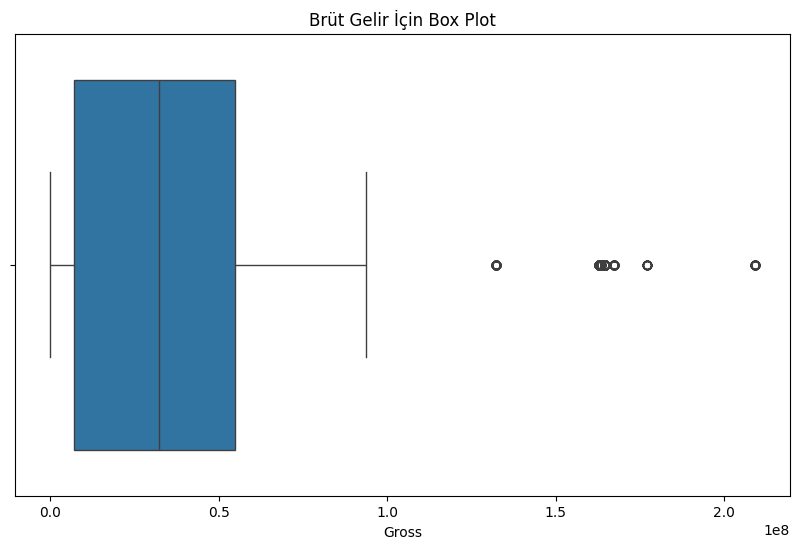

Aykırı Değerlerin Sayısı: 486


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mean Squared Error: 18356779263438.863
R^2 Score: 0.9670251046827911


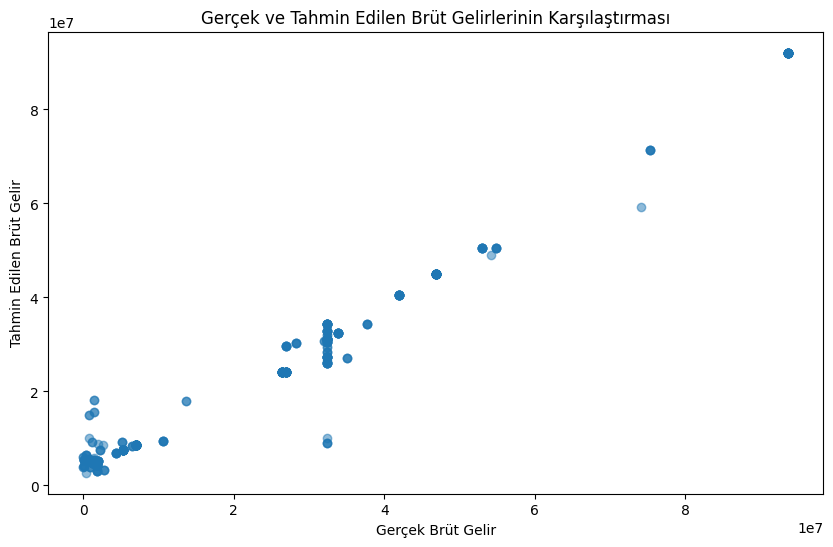

In [196]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Aykırı değerleri görselleştirme
plt.figure(figsize=(10, 6))
sns.boxplot(x=reremerged_df['Gross'])
plt.title('Brüt Gelir İçin Box Plot')
plt.show()

# Aykırı değerleri belirleme
Q1 = reremerged_df['Gross'].quantile(0.25)
Q3 = reremerged_df['Gross'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = reremerged_df[(reremerged_df['Gross'] < lower_bound) | (reremerged_df['Gross'] > upper_bound)]
print(f"Aykırı Değerlerin Sayısı: {len(outliers)}")

# Aykırı değerleri ele alma (örneğin, aykırı değerleri çıkarma)
reremerged_df_no_outliers = reremerged_df[~((reremerged_df['Gross'] < lower_bound) | (reremerged_df['Gross'] > upper_bound))]

# Yeni veri kümesini kullanarak modeli tekrar eğitme ve değerlendirme
X = reremerged_df_no_outliers.drop(columns=['Gross', 'Id', 'Title', 'Type', 'Description', 'Show_Id', 'Listed_In', 'Cast', 'Character'])
y = reremerged_df_no_outliers['Gross']

# Eğitim ve test veri setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline oluşturma
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Modeli eğitme
model.fit(X_train, y_train)

# Test veri seti ile tahminler yapma
y_pred = model.predict(X_test)

# Performans metrikleri
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Gerçek ve tahmin edilen değerlerin karşılaştırması
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Gerçek Brüt Gelir")
plt.ylabel("Tahmin Edilen Brüt Gelir")
plt.title("Gerçek ve Tahmin Edilen Brüt Gelirlerinin Karşılaştırması")
plt.show()
